In [38]:
#import section
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from PIL import Image
import os
# using dequeue because of atomar pop and append
from collections import deque
%matplotlib inline

# Define conversions in x and y from pixels space to meters
ym_per_pix = 3/64 # meters per pixel in y dimension
xm_per_pix = 3.7/900 # meters per pixel in x dimension

#Create object points for filling the array
#This was taken from the Lesson on Camera Calibration
objp =np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

#Create transformation matrix
#defined here because it is used later on to store the image transformation matrix
M=[]

In [91]:
# Define a class to receive the characteristics of each line detection
class Line():
    #max_iterations = 0
    def __init__(self,maxlen=0):
        # maximum of stored iteration results
        self.max_iterations = maxlen
        # iterations since start
        self.iteration_count = 0
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=self.max_iterations)
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.array([0,0,0], dtype='float')  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in meters
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
    def calc_curvature(self):
        poly=np.polyfit(self.ally*ym_per_pix,self.allx*xm_per_pix,2)
        #Calculate the curvature for the middle of the image
        y_eval=720*ym_per_pix/2
        self.radius_of_curvature = ((1+(2*poly[0]*y_eval+poly[1])**2)**(3/2))/(abs(2*poly[0]))
        
    def calc_avg(self):
        sumx=sum(self.recent_xfitted)
        self.bestx=sumx/len(self.recent_xfitted)
        self.best_fit=np.polyfit(np.linspace(0,719,720),self.bestx,2)
        
    def calc_x(self):
        ploty = np.linspace(0, 719, 720)
        try:
            fitx = self.current_fit[0]*ploty**2 + self.current_fit[1]*ploty + self.current_fit[2]
            self.recent_xfitted.append(fitx)
            self.calc_avg()
        except TypeError:
            print("Could not fit best poly")
        
            
    def fit_poly(self):
        poly=np.polyfit(self.ally,self.allx,2)
        if((poly.all() == True)):
            self.diffs = self.current_fit-poly
            self.current_fit=poly
            self.calc_x()
            self.calc_curvature()
            self.detected = True
        else:
            self.detected = False
        
    def add_values(self,x_vals,y_vals):
        self.allx = x_vals
        self.ally = y_vals
        self.fit_poly()
        
    def find_lane(self,image):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        lane_inds = ((nonzerox>=self.current_fit[0]*nonzeroy**2 + self.current_fit[1]*nonzeroy + self.current_fit[2]-margin)&
        (nonzerox<=self.current_fit[0]*nonzeroy**2 + self.current_fit[1]*nonzeroy + self.current_fit[2]+margin))
        
        if(len(lane_inds)>0):
            self.add_values( nonzerox[lane_inds],nonzeroy[lane_inds])
            if(self.detected == True):
                return True
        return False

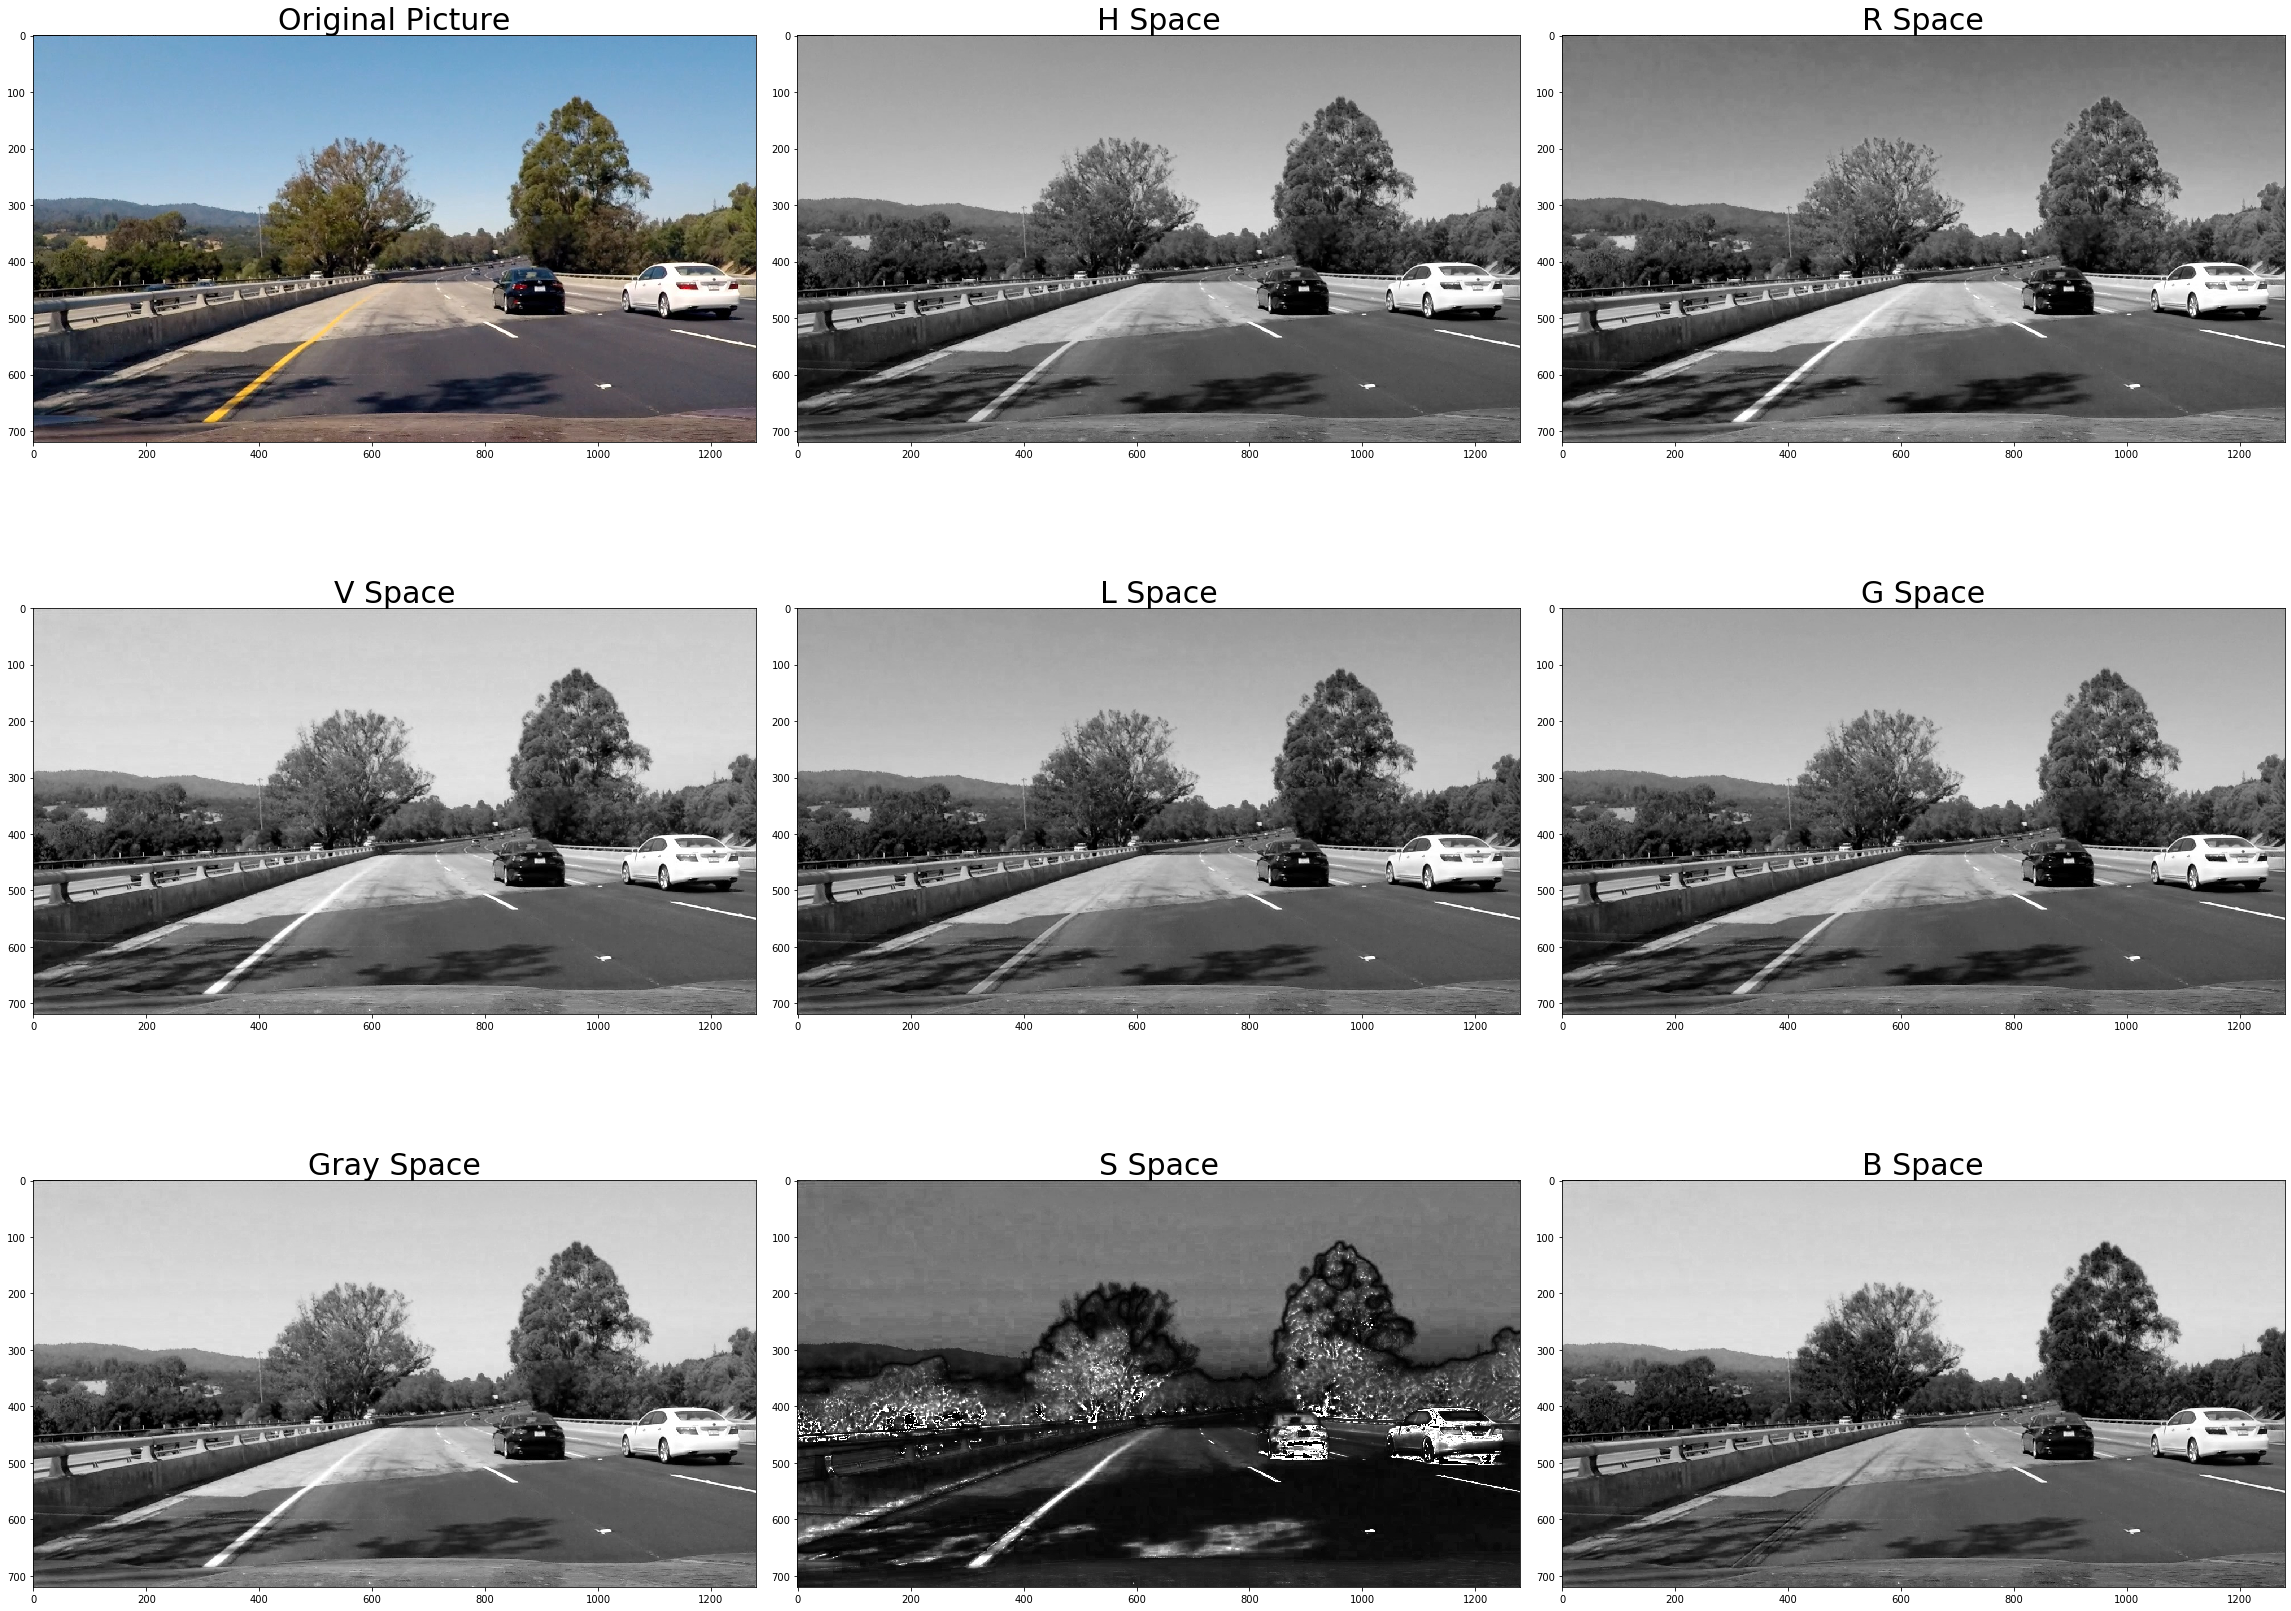

In [68]:
#Color spaces
image = mpimg.imread('test_images/test4.jpg')
fig, axs = plt.subplots(3, 3,figsize=(32, 24))
fig.tight_layout()
axs[0,0].set_title('Original Picture', fontsize=30)
axs[0,0].imshow(image)
axs[1,0].set_title('V Space', fontsize=30)
axs[1,0].imshow(cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,2],cmap='gray')
axs[2,0].set_title('Gray Space', fontsize=30)
axs[2,0].imshow(cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,2],cmap='gray')
axs[0,1].set_title('H Space', fontsize=30)
axs[0,1].imshow(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY),cmap='gray')
axs[1,1].set_title('L Space', fontsize=30)
axs[1,1].imshow(cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,1],cmap='gray')
axs[2,1].set_title('S Space', fontsize=30)
axs[2,1].imshow(cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2],cmap='gray')
axs[0,2].set_title('R Space', fontsize=30)
axs[0,2].imshow(image[:,:,0],cmap='gray')
axs[1,2].set_title('G Space', fontsize=30)
axs[1,2].imshow(image[:,:,1],cmap='gray')
axs[2,2].set_title('B Space', fontsize=30)
axs[2,2].imshow(image[:,:,2],cmap='gray')

In [69]:
#helper functions

#this function gets an image, detects the corners and writes them to the image points array
# also the corresponding object points, which are the same for all images are added to the object points array
#function is more or less taken from the lesson about camera calibration
def get_imagepoints_for_chessboard(filename, image_points, object_points, img_shape):
    #read in the image
    image=mpimg.imread(filename)
    #Convert the image to grayscale
    gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #find chessboard corners in image
    ret, corners = cv2.findChessboardCorners(gray_image,(9,6),None)
    #If corners are found add object and image points
    if(ret == True):
        image_points.append(corners)
        object_points.append(objp)
        
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    if(orient=='x'):
        sobel = cv2.Sobel(img,cv2.CV_64F,1,0)
    if(orient=='y'):
        sobel = cv2.Sobel(img,cv2.CV_64F,0,1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    abs_sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    abs_sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(np.power(abs_sobelx,2)+np.power(abs_sobely,2))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    abs_sobelx=np.absolute(cv2.Sobel(img,cv2.CV_64F,1,0,ksize=sobel_kernel))
    abs_sobely=np.absolute(cv2.Sobel(img,cv2.CV_64F,0,1,ksize=sobel_kernel))
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    atan_sobel=np.arctan2(abs_sobely,abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(atan_sobel)
    binary_output[(atan_sobel >= thresh[0]) & (atan_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

        
def find_lane_pixels(binary_warped):
    #print("Search for lane pixels")
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        #(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #(win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = np.where((nonzerox>=win_xleft_low) & (nonzerox<=win_xleft_high) & (nonzeroy>=win_y_low) & (nonzeroy<=win_y_high))
        good_right_inds = np.where((nonzerox>=win_xright_low) & (nonzerox<=win_xright_high) & (nonzeroy>=win_y_low) & (nonzeroy<=win_y_high))
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if(np.size(good_left_inds)>minpix):
            leftx_current=int(round(np.mean(nonzerox[good_left_inds])))
            
        if(np.size(good_right_inds)>minpix):
            rightx_current=int(round(np.mean(nonzerox[good_right_inds])))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds,axis=None)
        right_lane_inds = np.concatenate(right_lane_inds,axis=None)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

# Find second degree polynomial for the given left and right pixel positions and real world positions
def fit_polynomial(leftx, lefty, rightx, righty):

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    return left_fit,right_fit,left_fit_m,right_fit_m

def plot_pixels(leftx, lefty, rightx, righty,img):
                
    ## Visualization ##
    # Colors in the left and right lane regions
    img[lefty, leftx] = [255, 0, 0]
    img[righty, rightx] = [0, 0, 255]
    return img

def plot_polynomial(left_fit,right_fit,img):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
    #    # Avoids an error if `left` and `right_fit` are still none or incorrect
    #    print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    pts_left=np.vstack((left_fitx,ploty)).astype(np.int32).T
    pts_right=np.vstack((right_fitx,ploty)).astype(np.int32).T
    cv2.polylines(img,[pts_left,pts_right],False,(0, 255, 255),  10)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(img, np.int_([pts]), (0,255, 0))


def draw(leftx, lefty, rightx, righty,left_fit,right_fit,warped):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    plot_pixels(leftx, lefty, rightx, righty,color_warp)
    plot_polynomial(left_fit,right_fit,color_warp)
    
    return color_warp

def calc_offset(left_fit,right_fit,img):
    left_pos=left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2]
    right_pos=right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2]
    center=(left_pos+right_pos)/2
    offset=center-img.shape[1]/2
    offset_m = offset*xm_per_pix
    
    return offset_m

def calculate_curvature_real(left_fit_m,right_fit_m,img):
    #Calculate the curvature for the middle of the image
    y_eval=np.max(img.shape[0])*ym_per_pix/2
    left_curverad = ((1+(2*left_fit_m[0]*y_eval+left_fit_m[1])**2)**(3/2))/(abs(2*left_fit_m[0]))  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit_m[0]*y_eval+right_fit_m[1])**2)**(3/2))/(abs(2*right_fit_m[0]))  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

def display_measures(offset,left_cr,right_cr,img):
    scale =1
    dotsize =1
    
    avg_cr= (left_cr+right_cr)/2
    img = cv2.putText(img, 'Lane curvature: '+"{0:.2f}".format(avg_cr)+' m', (100,100), cv2.FONT_HERSHEY_SIMPLEX ,  
                       scale, (255,255, 255), dotsize, cv2.LINE_AA)
    img = cv2.putText(img, 'Vehicle Offset: '+"{0:.2f}".format(offset)+' m', (100,150), cv2.FONT_HERSHEY_SIMPLEX ,  
                       scale, (255,255, 255), dotsize, cv2.LINE_AA) 
    
def fit_lines(image,left_line,right_line):
    if((left_line.detected==False)|(right_line.detected==False)):
        print("No lines detected")
        leftx,lefty,rightx,righty=find_lane_pixels(image)
    if(left_line.detected==False):
        left_line.add_values(leftx,lefty)
    else:
        if(left_line.find_lane(image)==False):
            print("Left line not found, searching whole image")
            leftx,lefty,rightx,righty=find_lane_pixels(image)
            left_line.add_values(leftx,lefty)
    if(right_line.detected==False):
        right_line.add_values(rightx,righty)
    else:
        if(right_line.find_lane(image)==False):
            print("Right line not found, searching whole image")
            leftx,lefty,rightx,righty=find_lane_pixels(image)
            right_line.add_values(rightx,righty)
            

In [70]:
#Arrays to store the imagepoints and corresponding objectpoints
object_points=[]
image_points=[]
shape=[]

#read in images from calibration folder and calculate calibration parameters
images = glob.glob('camera_cal/calibration*.jpg')
shape=cv2.cvtColor(mpimg.imread(images[0]), cv2.COLOR_BGR2GRAY).shape[::-1]
for filename in images:  
    get_imagepoints_for_chessboard(filename,image_points,object_points,shape)
    
#calibrate the camera
ret, mtx, dist, rvecs, tvecs=cv2.calibrateCamera(object_points, image_points, shape,None,None) 
#test the result of the calibration
image = mpimg.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(image,mtx,dist,None,mtx)
im = Image.fromarray(undist)
im.save("output_images/undistorted.jpg")

#Calculate tranformation matrix
src = np.float32([[595,450],[685,450],[1110,720],[200,720]])
dst = np.float32([[200,100],[1110,100],[1110,720],[200,720]])
M=cv2.getPerspectiveTransform(src,dst)

In [71]:
      
def pipeline(img):
    img = np.copy(img)
    # Separate the R&G channel from the picture
    r_channel=img[:,:,0]
    g_channel=img[:,:,1]
    # Convert to HLS color space and separate the S channel
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Threshold magnitude and direction
    mag=mag_thresh(gray,sobel_kernel=3, mag_thresh=(30,100))
    direction=dir_threshold(gray, sobel_kernel=11, thresh=(0.7, 1.3))
    # Threshold color channel
    rb=np.zeros_like(r_channel)
    rb[(r_channel >= 160) & (r_channel <= 255)] = 1
    sb=np.zeros_like(r_channel)
    sb[(s_channel >= 115) & (s_channel <= 255)] = 1
    combined=np.zeros_like(s_channel)
    combined[((mag==1)&(direction==1))|((rb==1)&(sb==1))]=1
    return combined

def process_single_image(image):
    undist = cv2.undistort(image,mtx,dist,None,mtx)
    filtered = pipeline(undist)
    imp_arr = (np.ceil(filtered / 255.0) * 255.0).astype('uint8')
    warped=cv2.warpPerspective(imp_arr,M,(image.shape[1],image.shape[0]),flags=cv2.INTER_LINEAR)
    leftx,lefty,rightx,righty=find_lane_pixels(warped)
    left_fit,right_fit,left_fit_m,right_fit_m= fit_polynomial(leftx,lefty,rightx,righty)
    #fit_lines(warped,Left_line,Right_line)
    left_cr,right_cr=calculate_curvature_real(left_fit_m,right_fit_m,warped)
    #color_warp=draw(Left_line.allx, Left_line.ally, Right_line.allx, Right_line.ally,Left_line.current_fit,Right_line.current_fit,warped)
    color_warp=draw(leftx, lefty, rightx, righty,left_fit,right_fit,warped)
    newwarp = cv2.warpPerspective(color_warp, M,(image.shape[1],image.shape[0]),flags=cv2.INTER_LINEAR+cv2.WARP_INVERSE_MAP) 
    result = cv2.addWeighted(undist, 0.7, newwarp, 0.3, 0)
    offset = calc_offset(left_fit,right_fit,result)
    display_measures(offset,left_cr,right_cr,result)
    return result

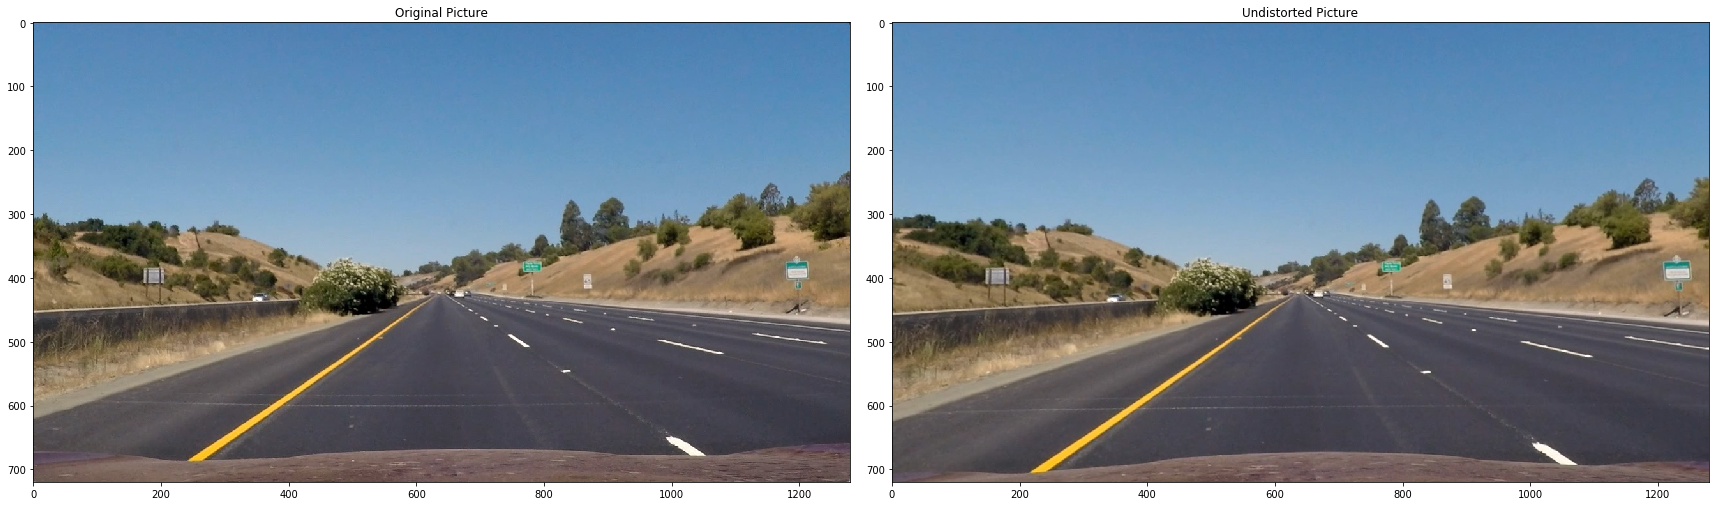

In [45]:
# Used to present the undistort function
image = mpimg.imread('test_images/straight_lines1.jpg')
undist = cv2.undistort(image,mtx,dist,None,mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Original Picture')
ax1.imshow(image)
ax2.set_title('Undistorted Picture')
ax2.imshow(undist)

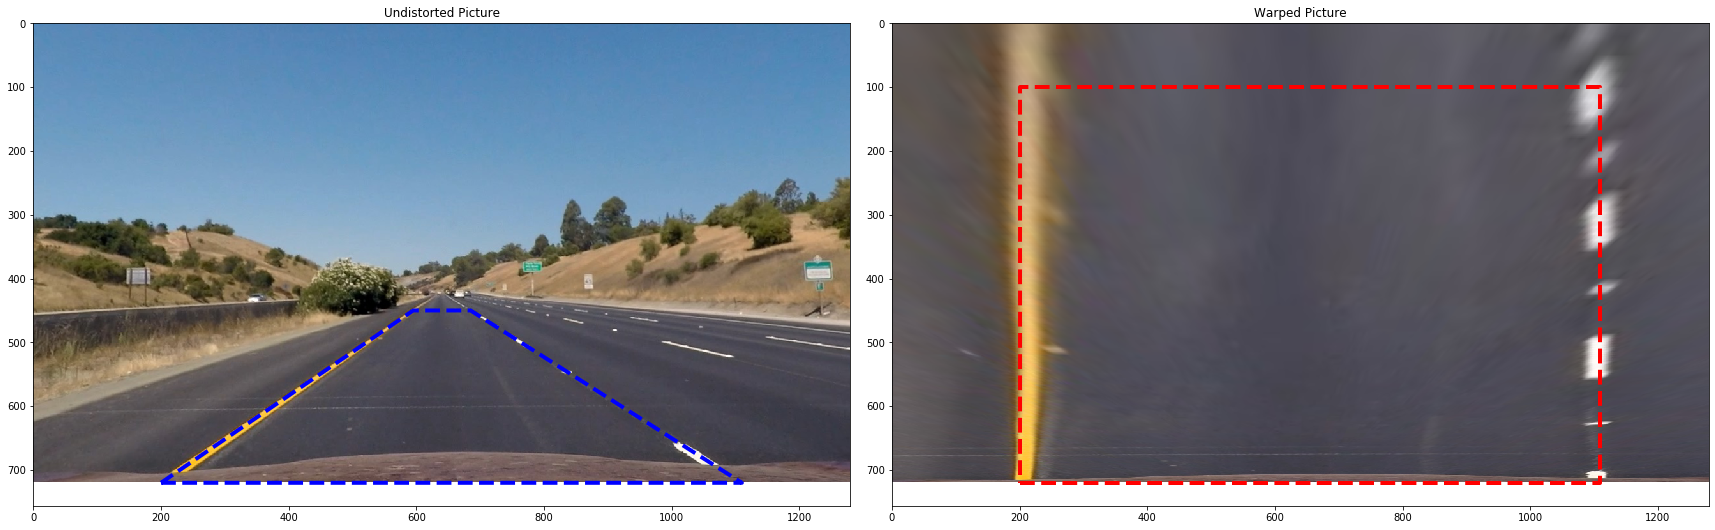

In [46]:
#Little helper to find the correct parameters for calculating the transformation matrix and also used to measure the length of the
# lane lines in pixels
image = mpimg.imread('test_images/straight_lines1.jpg')

src = np.float32([[595,450],[685,450],[1110,720],[200,720]])
dst = np.float32([[200,100],[1110,100],[1110,720],[200,720]])
M=cv2.getPerspectiveTransform(src,dst)
warped=cv2.warpPerspective(undist,M,(undist.shape[1],undist.shape[0]),flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Undistorted Picture')
ax1.imshow(undist)
x = [200, 1110, 685,595,200]
y = [720, 720, 450,450,720]
ax1.plot(x, y, 'b--', lw=4)
ax2.set_title('Warped Picture')
ax2.imshow(warped)
x2 = [200, 1110, 1110,200,200]
y2= [720, 720, 100,100,720]
ax2.plot(x2, y2, 'r--', lw=4)

In [64]:
# If the rms of the calibration is below 1.0 pixels it can be considered as succesful
if(ret < 1.0):
    images = glob.glob('test_images/*.jpg')
    for filename in images:         
        #Initialize line class 
        Left_line = Line(maxlen=10)
        Right_line = Line(maxlen=10)
        image_new = mpimg.imread(filename)
        im=process_single_image(image_new)
        pil_img=Image.fromarray(im, mode=None)
        pil_img.save(os.path.join("test_images_output/", filename))

720
720
720
720
720
720
720
720


In [92]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


#Initialize line class 
Left_line = Line(maxlen=10)
Right_line = Line(maxlen=10)

def process_video_image(image):
    undist = cv2.undistort(image,mtx,dist,None,mtx)
    filtered = pipeline(undist)
    imp_arr = (np.ceil(filtered / 255.0) * 255.0).astype('uint8')
    warped=cv2.warpPerspective(imp_arr,M,(image.shape[1],image.shape[0]),flags=cv2.INTER_LINEAR)
    fit_lines(warped,Left_line,Right_line)
    color_warp=draw(Left_line.allx, Left_line.ally, Right_line.allx, Right_line.ally,Left_line.best_fit,Right_line.best_fit,warped)
    newwarp = cv2.warpPerspective(color_warp, M,(image.shape[1],image.shape[0]),flags=cv2.INTER_LINEAR+cv2.WARP_INVERSE_MAP) 
    result = cv2.addWeighted(undist, 0.7, newwarp, 0.3, 0)
    offset = calc_offset(Left_line.current_fit,Right_line.current_fit,result)
    display_measures(offset,Left_line.radius_of_curvature,Right_line.radius_of_curvature,result)
    return result


white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("./project_video.mp4").subclip(0,1)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_video_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

No lines detected
[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4



  5%|████                                                                            | 65/1261 [00:33<09:34,  2.08it/s]


 10%|████████▏                                                                      | 131/1261 [01:05<09:25,  2.00it/s]


 16%|████████████▎                                                                  | 197/1261 [01:37<08:25,  2.11it/s]


 21%|████████████████▍                                                              | 263/1261 [02:11<07:47,  2.13it/s]


 26%|████████████████████▌                                                          | 329/1261 [02:43<07:40,  2.02it/s]


 31%|████████████████████████▋                                                      | 395/1261 [03:16<07:12,  2.00it/s]


 37%|████████████████████████████▉                                                  | 461/1261 [03:49<06:29,  2.05it/s]


 42%|█████████████████████████████████                                              | 527/1261 [04:27<06:16,  1.95it/s]


 47%|█████████████████████████████████████▏                                         | 593/1261 [04:59<05:40,  1.96it/s]


 52%|█████████████████████████████████████████▎                                     | 659/1261 [05:36<05:22,  1.87it/s]


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [06:13<04:30,  1.98it/s]


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [06:48<03:50,  2.04it/s]


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [07:23<03:30,  1.92it/s]


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [07:57<03:29,  1.62it/s]


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [08:32<02:19,  1.96it/s]


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [09:07<01:59,  1.73it/s]


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [09:42<01:10,  1.98it/s]


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [10:22<00:38,  1.91it/s]


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [10:55<00:04,  1.92it/s]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:58<00:00,  1.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 11min 1s
